# Text Mining and Search Project
## Text Classification and Sentiment Analysis on the 20newsgroups dataset
author: Louis Fabrice Tshimanga 847529 l.tshimanga@campus.unimib.it

### Tasks:
* Preprocessing
* **Classification**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import sklearn
from sklearn.utils import shuffle
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

from keras.models import Sequential
#from keras.layers import Dense, Dropout, TimeDistributed, Embedding, GRU
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences


In [2]:
# Load the training dataset

from sklearn.datasets import fetch_20newsgroups
tngds_train = fetch_20newsgroups(subset='train', remove=('headers', 'footers', 'quotes'), shuffle=True)

# Check categories
tngds_train.target_names 

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

In [3]:
# Print part of an instance
print("\n".join(tngds_train.data[0].split("\n")[:10]))

I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were really small. In addition,
the front bumper was separate from the rest of the body. This is 
all I know. If anyone can tellme a model name, engine specs, years
of production, where this car is made, history, or whatever info you
have on this funky looking car, please e-mail.


In [4]:
# Build feature vectors where each document is put as a vector of tf-idf values by its word content
vectorizer = TfidfVectorizer()
vectors_train = vectorizer.fit_transform(tngds_train.data)
vectors_train.shape

(11314, 101631)

In [5]:
# We have 11314 vectors of 101631 word-features, let's check vectors' sparsity
vectors_train.nnz / float(vectors_train.shape[0]) # non-zero values / number of vectors
# result is average nnz values in each vector

97.54525366802191

In [6]:
# Define a pipeline for transforming and training an ML algo
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier # SVM model for multiple classes
text_clf = Pipeline([
                     ('tfidfvect', vectorizer),
                     ('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=13,max_iter=10, tol=None))
])

In [7]:
text_clf.fit(tngds_train.data, tngds_train.target) # training of the SVM

tngds_test = fetch_20newsgroups(subset='test', remove=('headers', 'footers', 'quotes'), shuffle=True) # test set loading
data_test = tngds_test.data

predicted = text_clf.predict(data_test) # classification
np.mean(predicted == tngds_test.target) # pure accuracy

0.6838821030270844

                          precision    recall  f1-score   support

             alt.atheism       0.57      0.40      0.47       319
           comp.graphics       0.70      0.66      0.68       389
 comp.os.ms-windows.misc       0.64      0.62      0.63       394
comp.sys.ibm.pc.hardware       0.69      0.62      0.65       392
   comp.sys.mac.hardware       0.74      0.70      0.72       385
          comp.windows.x       0.75      0.72      0.73       395
            misc.forsale       0.48      0.85      0.61       390
               rec.autos       0.78      0.70      0.74       396
         rec.motorcycles       0.77      0.77      0.77       398
      rec.sport.baseball       0.81      0.78      0.80       397
        rec.sport.hockey       0.80      0.91      0.85       399
               sci.crypt       0.71      0.74      0.72       396
         sci.electronics       0.67      0.49      0.57       393
                 sci.med       0.73      0.79      0.76       396
         

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


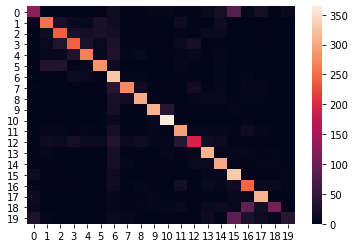

In [8]:
print(classification_report(tngds_test.target, predicted, target_names=tngds_test.target_names))
cf_matrix = confusion_matrix(tngds_test.target, predicted)
import seaborn as sns
sns.heatmap(cf_matrix, annot=False)

Now let's pre-process properly our documents, removing stop-words, tokenizing, normalizing and so on.

In [9]:
text_clf2 = Pipeline([
                     ('tfidfvect', TfidfVectorizer(strip_accents='unicode', stop_words='english', max_features=20000)),
                     ('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=13,max_iter=10, tol=None))
])
text_clf2.fit(tngds_train.data, tngds_train.target) # training of the SVM

predicted = text_clf2.predict(data_test) # classification
np.mean(predicted == tngds_test.target) # pure accuracy

0.679368029739777

In [10]:
# Tokenizing
from nltk.tokenize import WhitespaceTokenizer
def mytokenizer(text):
    tokenizer = WhitespaceTokenizer()
    tokenized_list = tokenizer.tokenize(text) 
    return tokenized_list

# Stemming
from nltk.stem.snowball import SnowballStemmer
def mystemmer(text):
    snowball = SnowballStemmer(language='english')
    stemlist = []
    for i in range(len(text)):
        stemlist.append(snowball.stem(text[i]))
    return str(stemlist)
# 

# Make functions as pipelines
# Adapted from https://ryan-cranfill.github.io/sentiment-pipeline-sklearn-3/
from sklearn.preprocessing import FunctionTransformer
def pipelinize(function, active=True):
    def list_comprehend_a_function(list_or_series, active=True):
        if active:
            return [function(i) for i in list_or_series]
        else: # if it's not active, just pass it right back
            return list_or_series
    return FunctionTransformer(list_comprehend_a_function, validate=False, kw_args={'active':active})
  
fullprocess_clf = [ ('tokenizer', pipelinize(mytokenizer)),
              ('stemmer', pipelinize(mystemmer)),
              ('tfidfvect', TfidfVectorizer(strip_accents='unicode', stop_words='english', max_features=20000)),
              ('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=13,max_iter=10, tol=None))]

preprocess = [ ('tokenizer', pipelinize(mytokenizer)),
              ('stemmer', pipelinize(mystemmer)),
              ('tfidfvect', TfidfVectorizer(strip_accents='unicode', stop_words='english', max_features=20000))]

In [11]:
text_clf3 = Pipeline(fullprocess_clf)
text_clf3.fit(tngds_train.data, tngds_train.target) # training of the SVM

predicted = text_clf3.predict(data_test) # classification
np.mean(predicted == tngds_test.target) # pure accuracy

0.6768454593733404

                          precision    recall  f1-score   support

             alt.atheism       0.60      0.40      0.48       319
           comp.graphics       0.67      0.66      0.67       389
 comp.os.ms-windows.misc       0.65      0.57      0.61       394
comp.sys.ibm.pc.hardware       0.70      0.62      0.66       392
   comp.sys.mac.hardware       0.69      0.71      0.70       385
          comp.windows.x       0.77      0.75      0.76       395
            misc.forsale       0.69      0.77      0.73       390
               rec.autos       0.75      0.70      0.73       396
         rec.motorcycles       0.49      0.76      0.60       398
      rec.sport.baseball       0.81      0.79      0.80       397
        rec.sport.hockey       0.78      0.92      0.84       399
               sci.crypt       0.71      0.73      0.72       396
         sci.electronics       0.64      0.49      0.55       393
                 sci.med       0.75      0.79      0.77       396
         

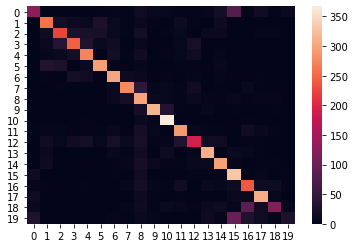

In [12]:
print(classification_report(tngds_test.target, predicted, target_names=tngds_test.target_names))
cf_matrix = confusion_matrix(tngds_test.target, predicted)
sns.heatmap(cf_matrix, annot=False)

In [13]:
print(cf_matrix)

[[128   2   0   1   1   3   5   4  14   7   6   4   4   7  18  80   4  16
    4  11]
 [  1 257  21  12   9  28  10   4   9   3   0  12   3   1  14   2   0   2
    0   1]
 [  2  16 224  26  24  23  10   3  19   2   4   8   1   9  10   0   2   5
    5   1]
 [  0   9  36 244  29   9  16   1   8   2   2   7  22   2   2   0   0   1
    1   1]
 [  0   6  10  21 273   3  18   4  17   0   3   7  14   2   5   0   2   0
    0   0]
 [  0  34  26   1   9 295   3   1   7   0   1   4   3   2   8   0   0   1
    0   0]
 [  1   4   2  19  15   0 302  12  10   2   3   2   5   0   5   2   2   4
    0   0]
 [  1   2   3   0   2   1  11 278  45   5   6   3  16   2   4   0   9   4
    2   2]
 [  0   1   1   1   0   2  11  21 301  10   7   3   9   5   4   6   4   5
    5   2]
 [  1   1   2   1   0   1   2   1  21 314  33   3   1   6   1   4   1   1
    3   0]
 [  0   0   0   1   4   0   0   1  10   5 367   1   1   1   1   2   4   1
    0   0]
 [  4   5   5   2   3   4   7   2  20   6   2 290   7   5   4   2

It's possible that part of the slight decrease in accuracy was due to preprocessing, particularly stemming, because different topics may be differently using peculiar versions of words from the same root. Another possibility is that the problem is simply not well suited for our classifier model, which is a linear separator.
To check for this, we'll implement a very different classifier.

In [14]:
from sklearn.naive_bayes import MultinomialNB # SVM model for multiple classes
text_clf4 = Pipeline([
                     ('tfidfvect', vectorizer),
                     ('clf', MultinomialNB(0.1))
])
text_clf4.fit(tngds_train.data, tngds_train.target) # training of NB

predicted = text_clf4.predict(data_test) # classification
np.mean(predicted == tngds_test.target) # pure accuracy

0.6845459373340415

In [15]:
text_clf5 = Pipeline([
                     ('tfidfvect', TfidfVectorizer(strip_accents='unicode', stop_words='english', max_features=20000)),
                     ('clf', MultinomialNB(0.1))
])
text_clf5.fit(tngds_train.data, tngds_train.target) # training of NB

predicted = text_clf5.predict(data_test) # classification
np.mean(predicted == tngds_test.target) # pure accuracy

0.6976898566117897

In [16]:
fullprocess_nb = [ ('tokenizer', pipelinize(mytokenizer)),
              ('stemmer', pipelinize(mystemmer)),
              ('tfidfvect', TfidfVectorizer(strip_accents='unicode', stop_words='english', max_features=20000)),
              ('clf', MultinomialNB(0.1))]
text_clf6 = Pipeline(fullprocess_nb)
text_clf6.fit(tngds_train.data, tngds_train.target) # training of NB

predicted = text_clf6.predict(data_test) # classification
np.mean(predicted == tngds_test.target) # pure accuracy

0.6970260223048327

Stemming is confirmed as a candidate for accuracy decreases. Let's try with Lemmatization instead.

In [17]:
# Lemmatization
import nltk
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
def mylemma(text):
    lemma = WordNetLemmatizer()
    lemlist = []
    for i in range(len(text)):
        lemlist.append(lemma.lemmatize(text[i]))
    return str(lemlist)

fullprocess_nb = [ ('tokenizer', pipelinize(mytokenizer)),
              ('lemma', pipelinize(mylemma)),
              ('tfidfvect', TfidfVectorizer(strip_accents='unicode', stop_words='english', max_features=20000)),
              ('clf', MultinomialNB(0.1))]
text_clf7 = Pipeline(fullprocess_nb)
text_clf7.fit(tngds_train.data, tngds_train.target) # training of NB

predicted = text_clf7.predict(data_test) # classification
np.mean(predicted == tngds_test.target) # pure accuracy

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


0.7003451938396177

Lemmatization actually improves performance (though slightly)!


Let's now reduce our problem to a subset of classes chosen in such a way:
for every class prefix (identifying a "supervised cluster"), select the most numerous class.

In [18]:
cats = ['alt.atheism', 'comp.windows.x', 'misc.forsale', 'rec.sport.hockey', 'sci.crypt', 'soc.religion.christian', 'talk.politics.mideast']


In [19]:
reduced_train = fetch_20newsgroups(subset='train', categories=cats, remove=('headers', 'footers', 'quotes'), shuffle=True)

# Check categories
reduced_train.target_names 

['alt.atheism',
 'comp.windows.x',
 'misc.forsale',
 'rec.sport.hockey',
 'sci.crypt',
 'soc.religion.christian',
 'talk.politics.mideast']

In [20]:
reduced_test = fetch_20newsgroups(subset='test', categories=cats, remove=('headers', 'footers', 'quotes'), shuffle=True) # test set loading
data_test = reduced_test.data

In [21]:
text_clf8 = Pipeline(fullprocess_nb)
text_clf8.fit(reduced_train.data, reduced_train.target) # training of NB

predicted = text_clf8.predict(data_test) # classification
np.mean(predicted == reduced_test.target) # pure accuracy

0.8451178451178452

                        precision    recall  f1-score   support

           alt.atheism       0.79      0.49      0.61       319
        comp.windows.x       0.93      0.91      0.92       395
          misc.forsale       0.93      0.92      0.92       390
      rec.sport.hockey       0.81      0.96      0.88       399
             sci.crypt       0.89      0.83      0.86       396
soc.religion.christian       0.71      0.90      0.79       398
 talk.politics.mideast       0.89      0.84      0.86       376

              accuracy                           0.85      2673
             macro avg       0.85      0.84      0.83      2673
          weighted avg       0.85      0.85      0.84      2673



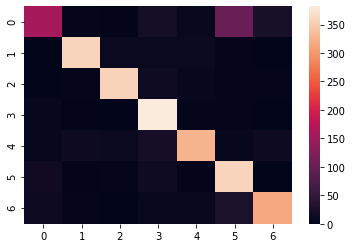

In [22]:
print(classification_report(reduced_test.target, predicted, target_names=reduced_test.target_names))
cf_matrix = confusion_matrix(reduced_test.target, predicted)
sns.heatmap(cf_matrix, annot=False)

In [23]:
print(cf_matrix)

[[157   4   2  20   8 104  24]
 [  0 359  10  11  11   4   0]
 [  0   4 358  14   7   4   3]
 [  6   2   0 382   4   4   1]
 [  6  12  11  22 327   6  12]
 [ 16   2   4  14   2 359   1]
 [ 13   3   0   8   8  27 317]]


The topical distinction is much improved, the strongest "unwanted" correlation is between alt.atheism and soc.religion.christianity.
Topic modelling and unsupervised methods may bring a different cathegorization of documents, that might be easier for supervised models to learn and predict on its own. 